In [8]:
import numpy as np
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

In [9]:
# Load the SST dataset's training split
train_data = load_dataset('sst', split='train', trust_remote_code=True)
train_data = pd.DataFrame(train_data)

# Load the SST dataset's validation split
val_data = load_dataset('sst', split='validation', trust_remote_code=True)
val_data = pd.DataFrame(val_data)

# Load the SST dataset's test split
test_data = load_dataset('sst', split='test', trust_remote_code=True)
test_data = pd.DataFrame(test_data)

# concatenate the training and validation data and the test data
data = pd.concat([train_data, val_data, test_data])


## Data Preparation

In [10]:
def score_to_class(score):
    if score <= 0.2:
        return 0
    elif score <= 0.4:
        return 1
    elif score <= 0.6:
        return 2
    elif score <= 0.8:
        return 3
    else:
        return 4

def clean_text(text):
    # Remove non-alphabetic characters and lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove words with 2 or fewer characters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Remove consecutive spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning and score mapping on each dataset
data['sentence'] = data['sentence'].apply(lambda x: clean_text(x.lower()))
data['label'] = data['label'].apply(lambda x: score_to_class(x))

# Display cleaned samples from each data
print("Data samples after cleaning:")
print(data.head())


Data samples after cleaning:
                                            sentence  label  \
0  the rock destined the century new conan and th...      3   
1  the gorgeously elaborate continuation the lord...      4   
2  singercomposer bryan adams contributes slew so...      3   
3  you think now america would have had enough pl...      2   
4                    yet the act still charming here      3   

                                              tokens  \
0  The|Rock|is|destined|to|be|the|21st|Century|'s...   
1  The|gorgeously|elaborate|continuation|of|``|Th...   
2  Singer\/composer|Bryan|Adams|contributes|a|sle...   
3  You|'d|think|by|now|America|would|have|had|eno...   
4               Yet|the|act|is|still|charming|here|.   

                                                tree  
0  70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|5...  
1  71|70|69|69|67|67|66|64|63|62|62|61|61|58|57|5...  
2  72|71|71|70|68|68|67|67|66|63|62|62|60|60|58|5...  
3  36|35|34|33|33|32|30|29|27|26|25

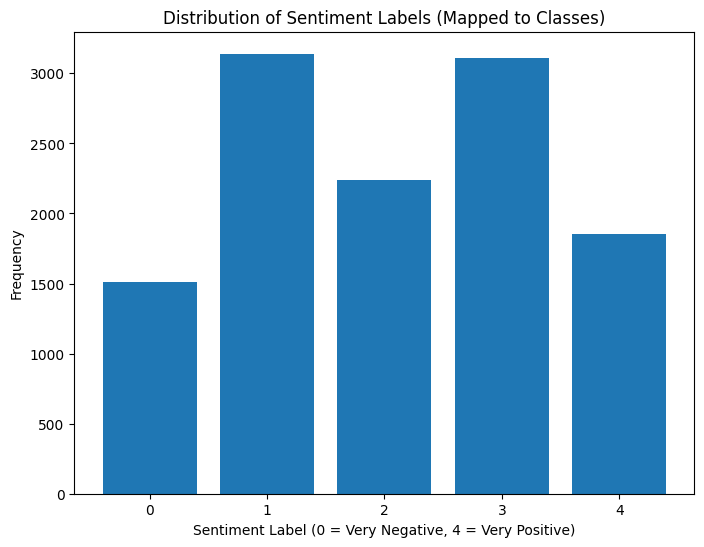

In [11]:
# Plotting the distribution of sentiment labels after mapping scores to classes
data_label_counts = data['label'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(data_label_counts.index, data_label_counts.values)
plt.xlabel("Sentiment Label (0 = Very Negative, 4 = Very Positive)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Labels (Mapped to Classes)")
plt.show()


In [12]:
#divide the data into training 90% and testing 10% so that both have the same distribution of sentiment labels
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)

# Display a few samples from the train and test sets to verify the split
print("Training data samples:")
print(train_data.head())
print("\nTesting data samples:")
print(test_data.head())

# Display the distribution of labels in the training and test sets to verify the stratification
print("\nLabel distribution in training data:")
print(train_data['label'].value_counts(normalize=True))
print("\nLabel distribution in testing data:")
print(test_data['label'].value_counts(normalize=True))

Training data samples:
                                               sentence  label  \
2134  usually when get this much syrup like pancakes...      1   
1053  mattei tiresomely grave and longwinded circula...      0   
6071  goodlooking but relentlessly lowbrow outing pl...      1   
807   fooled the impressive cast list eye see you pu...      0   
2087             sushi for the connoisseurs the macabre      1   

                                                 tokens  \
2134  Usually|when|I|get|this|much|syrup|,|I|like|pa...   
1053  Mattei|is|tiresomely|grave|and|long-winded|,|a...   
6071  Good-looking|but|relentlessly|lowbrow|outing|p...   
807   Do|n't|be|fooled|by|the|impressive|cast|list|-...   
2087        Sushi|for|the|connoisseurs|of|the|macabre|.   

                                                   tree  
2134  30|29|28|27|26|25|25|24|23|21|20|19|18|17|17|2...  
1053  27|23|22|20|20|21|24|19|18|17|16|15|15|26|16|1...  
6071  20|20|21|19|19|17|16|15|14|13|13|18|14|15|16|

# Part 2: Logistic Regression

In [13]:
# create x and y train
x_train = train_data['sentence']
y_train = train_data['label']

# create x and y test
x_test = test_data['sentence']
y_test = test_data['label']

In [14]:
#create one hot encoding for y_train, y_val, y_test
def one_hot_encode(y, num_classes):
    v = np.zeros((len(y), num_classes))
    v[np.arange(len(y)), y] = 1
    return v

y_train = one_hot_encode(y_train, 5)
y_test = one_hot_encode(y_test, 5)

print("y_train one-hot encoded shape:", y_train.shape)
print("y_train one-hot encoded:")
print(y_train)
print("-" * 50)
print("y_test one-hot encoded shape:", y_test.shape)
print("y_test one-hot encoded:")
print(y_test)

y_train one-hot encoded shape: (10669, 5)
y_train one-hot encoded:
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
--------------------------------------------------
y_test one-hot encoded shape: (1186, 5)
y_test one-hot encoded:
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [18]:
# combine x_train and x_val and x_test
x_combined = pd.concat([x_train, x_test], axis=0)
print("Combined x shape:", x_combined.shape)

# extract the Bigrams from the combined x sentences
bigrams = []
for sentence in x_combined:
    words = sentence.split(" ")
    for i in range(len(words) - 1):
        bigrams.append((words[i], words[i + 1]))
        
unique_bigrams = set(bigrams)
print("Number of unique bigrams:", len(unique_bigrams))
print("First 10 bigrams:", bigrams[:10])



Combined x shape: (11855,)
Number of unique bigrams: 99805
First 10 bigrams: [('usually', 'when'), ('when', 'get'), ('get', 'this'), ('this', 'much'), ('much', 'syrup'), ('syrup', 'like'), ('like', 'pancakes'), ('pancakes', 'with'), ('mattei', 'tiresomely'), ('tiresomely', 'grave')]


In [19]:
# create a sparse matrix for bigrams for colums and sentences for rows
def create_bigram_sparse_matrix(sentences, bigrams):
    bigram_sparse_matrix = np.zeros((len(sentences), len(bigrams)))
    bigram_to_index = {bigram: i for i, bigram in enumerate(bigrams)}
    for i, sentence in enumerate(sentences):
        words = sentence.split(" ")
        for j in range(len(words) - 1):
            bigram = (words[j], words[j + 1])
            bigram_sparse_matrix[i, bigram_to_index[bigram]] = 1
    return bigram_sparse_matrix

In [20]:
x_train_bigram_sparse = create_bigram_sparse_matrix(x_train, unique_bigrams)
x_test_bigram_sparse = create_bigram_sparse_matrix(x_test, unique_bigrams)

print("x_train_bigram_sparse shape:", x_train_bigram_sparse.shape)
print("x_test_bigram_sparse shape:", x_test_bigram_sparse.shape)

x_train_bigram_sparse shape: (10669, 99805)
x_test_bigram_sparse shape: (1186, 99805)


## Create Model

In [129]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred, weights, lambda_reg):
    # Compute standard cross-entropy loss
    base_loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    # Add L2 regularization term
    l2_penalty = (lambda_reg / (2 * len(y_true))) * np.sum(np.square(weights))
    return base_loss + l2_penalty

def accuracy(y_true, y_pred):
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    return np.mean(y_true_labels == y_pred_labels)

class LogisticRegression:
    def __init__(self, num_features, lambda_reg=0.01):
        self.num_features = num_features
        self.lambda_reg = lambda_reg
        # Xavier (Glorot) Initialization
        self.weights = np.random.uniform(
            -np.sqrt(6 / (num_features + 5)), 
            np.sqrt(6 / (num_features + 5)), 
            (num_features, 5)
        )
        self.bias = np.zeros(5)
        
    def forward(self, x):
        return softmax(np.dot(x, self.weights) + self.bias)
    
    def backward(self, x, y_true, y_pred, learning_rate):
        # Calculate the gradients with L2 regularization
        m = len(y_true)
        grad_w = np.dot(x.T, (y_pred - y_true)) / m
        grad_b = np.sum(y_pred - y_true, axis=0) / m
        # Add L2 regularization term to weight gradients
        grad_w += (self.lambda_reg / m) * self.weights
        
        # Update weights and biases
        self.weights -= learning_rate * grad_w
        self.bias -= learning_rate * grad_b
        
    def train(self, x, y, learning_rate, epochs):
        # Create a history of loss and accuracy
        history = {"loss": [], "accuracy": []}
        for epoch in range(epochs):
            # Shuffle the data at the start of each epoch
            indices = np.arange(len(y))
            np.random.shuffle(indices)
            x = x[indices]
            y = y[indices]
            
            # Forward pass, calculate loss and accuracy, and perform backward pass
            y_pred = self.forward(x)
            loss = cross_entropy_loss(y, y_pred, self.weights, self.lambda_reg)
            acc = accuracy(y, y_pred)
            history["loss"].append(loss)
            history["accuracy"].append(acc)
            self.backward(x, y, y_pred, learning_rate)
            
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.6f} - Accuracy: {acc:.6f}")
        return history
            
    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred, self.weights, self.lambda_reg)
        acc = accuracy(y, y_pred)
        print(f"Loss: {loss:.6f} - Accuracy: {acc:.6f}")
        
    def predict(self, x):
        return np.argmax(self.forward(x), axis=1)


In [130]:
# create the model
lr = 0.005
epochs = 200
lambda_reg = 0.01
LogisticRegression_model = LogisticRegression(x_train_bigram_sparse.shape[1],lambda_reg)

In [131]:
# train the model
history = LogisticRegression_model.train(x_train_bigram_sparse, y_train, lr, epochs)

Epoch 1/250 - Loss: 1.609475 - Accuracy: 0.207631
Epoch 2/250 - Loss: 1.609385 - Accuracy: 0.209504
Epoch 3/250 - Loss: 1.609296 - Accuracy: 0.211142
Epoch 4/250 - Loss: 1.609207 - Accuracy: 0.211845
Epoch 5/250 - Loss: 1.609117 - Accuracy: 0.213249
Epoch 6/250 - Loss: 1.609028 - Accuracy: 0.215356
Epoch 7/250 - Loss: 1.608939 - Accuracy: 0.216409
Epoch 8/250 - Loss: 1.608851 - Accuracy: 0.219335
Epoch 9/250 - Loss: 1.608762 - Accuracy: 0.222729
Epoch 10/250 - Loss: 1.608674 - Accuracy: 0.224017
Epoch 11/250 - Loss: 1.608586 - Accuracy: 0.225187
Epoch 12/250 - Loss: 1.608498 - Accuracy: 0.225187
Epoch 13/250 - Loss: 1.608410 - Accuracy: 0.226475
Epoch 14/250 - Loss: 1.608322 - Accuracy: 0.227528
Epoch 15/250 - Loss: 1.608234 - Accuracy: 0.228581
Epoch 16/250 - Loss: 1.608147 - Accuracy: 0.230454
Epoch 17/250 - Loss: 1.608060 - Accuracy: 0.231156
Epoch 18/250 - Loss: 1.607973 - Accuracy: 0.232444
Epoch 19/250 - Loss: 1.607886 - Accuracy: 0.233614
Epoch 20/250 - Loss: 1.607799 - Accuracy

In [ ]:
# plot the loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(history["accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [125]:
import numpy as np

# Get confusion matrix with rows as actual classes and columns as predicted classes
def get_confusion_matrix(predicted, actual):
    classes = np.unique(actual)
    n = len(classes)
    confusion_matrix = np.zeros((n, n), dtype=int)
    for a, p in zip(actual, predicted):
        confusion_matrix[a, p] += 1
    return confusion_matrix

# Get macro-averaged precision over all classes
def precision(confusion_matrix):
    avg_precision = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fp = np.sum(confusion_matrix[:, c]) - tp
        # Avoid division by zero
        if (tp + fp) > 0:
            avg_precision += tp / (tp + fp)
    return avg_precision / confusion_matrix.shape[0]

# Get macro-averaged recall over all classes
def recall(confusion_matrix):
    avg_recall = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fn = np.sum(confusion_matrix[c, :]) - tp
        # Avoid division by zero
        if (tp + fn) > 0:
            avg_recall += tp / (tp + fn)
    return avg_recall / confusion_matrix.shape[0]

# Get macro-averaged F1 score over all classes
def f1_score(confusion_matrix):
    avg_f1 = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fp = np.sum(confusion_matrix[:, c]) - tp
        fn = np.sum(confusion_matrix[c, :]) - tp
        # Calculate precision and recall, avoid division by zero in F1 calculation
        if (tp + fp) > 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
        if (tp + fn) > 0:
            recall = tp / (tp + fn)
        else:
            recall = 0
        if (precision + recall) > 0:
            avg_f1 += 2 * (precision * recall) / (precision + recall)
    return avg_f1 / confusion_matrix.shape[0]


In [126]:
# evaluate the model
print("Train Data:")
LogisticRegression_model.evaluate(x_train_bigram_sparse, y_train)

print("\nValidation Data:")
LogisticRegression_model.evaluate(x_val_bigram_sparse, y_val)

print("\nTest Data:")
LogisticRegression_model.evaluate(x_test_bigram_sparse, y_test)

Train Data:
Loss: 0.858605 - Accuracy: 0.287687

Validation Data:
Loss: 0.859723 - Accuracy: 0.262489

Test Data:
Loss: 0.860631 - Accuracy: 0.248869


In [127]:
# Get the confusion matrix
conf_matrix = get_confusion_matrix(LogisticRegression_model.predict(x_val_bigram_sparse), np.argmax(y_val, axis=1))

# Calculate precision, recall, and F1 score using the confusion matrix
prec = precision(conf_matrix)
rec = recall(conf_matrix)
f1 = f1_score(conf_matrix)

print("Confusion Matrix:\n", conf_matrix)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Confusion Matrix:
 [[  0  37   0 102   0]
 [  0  82   0 207   0]
 [  0  54   0 175   0]
 [  0  72   0 207   0]
 [  0  38   0 127   0]]
Precision: 0.10856177697910097
Recall: 0.20513450161848423
F1 Score: 0.13282123528249326


In [128]:
# Get the confusion matrix
conf_matrix = get_confusion_matrix(LogisticRegression_model.predict(x_test_bigram_sparse), np.argmax(y_test, axis=1))

# Calculate precision, recall, and F1 score using the confusion matrix
prec = precision(conf_matrix)
rec = recall(conf_matrix)
f1 = f1_score(conf_matrix)

print("Confusion Matrix:\n", conf_matrix)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

Confusion Matrix:
 [[  0  72   0 207   0]
 [  0 177   0 456   0]
 [  0  99   0 290   0]
 [  0 137   0 373   0]
 [  0 104   0 295   0]]
Precision: 0.1061228422791272
Recall: 0.2021986804200353
F1 Score: 0.1279518847716777
